# Введение:
Этот проект посвящен созданию нейросетевой модели для генерации классической музыки.

В процессе работы используются MIDI файлы известных композиторов, которые анализируются, а затем на их основе создается новая музыкальная композиция с использованием LSTM модели.

Основная цель проекта — исследовать возможности машинного обучения в области музыкальной генерации.

# Установка и импорт необходимых библиотек

In [ ]:
# Установка библиотеки music21 для работы с MIDI файлами
!pip install --upgrade music21  # Анализ и парсинг MIDI файлов

# Установка FluidSynth для синтеза аудио из MIDI
!sudo apt install -y fluidsynth  # Синтезатор для воспроизведения MIDI

# Установка PyFluidSynth для взаимодействия с FluidSynth из Python
!pip install --upgrade pyfluidsynth  # Python-обертка для FluidSynth

# Добавление PPA для установки MuseScore
!add-apt-repository ppa:mscore-ubuntu/mscore-stable -y  # PPA (Personal Package Archive) для получения последней стабильной версии MuseScore
!apt-get update

# Установка программы MuseScore для отображения нот
!apt-get install musescore  # Генерация изображений нот

# Установка Xvfb для запуска MuseScore в виртуальном фреймбуфере
!apt-get install xvfb  # Виртуальный фреймбуфер для Colab

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0
  libinput-bin libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libx

In [ ]:
from music21 import environment, converter, instrument, note, chord, stream
import warnings
import numpy as np
import os
from collections import Counter
import matplotlib.pyplot as plt
from collections import Counter
import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import random

In [ ]:
# Отключение предупреждений
warnings.filterwarnings("ignore")

# Константы

In [ ]:
np.random.seed(42)
DATASET_PATH = "./dataset/"
length = 40
EPOCHS = 150  # Количество эпох
BATCH_SIZE = 64  # Размер батча

# Настройка окружения для music21

In [ ]:
# настраиваем окружение в соответствии с документацией
us = environment.UserSettings()
us['musescoreDirectPNGPath'] = '/usr/bin/mscore'  # Путь к MuseScore
us['directoryScratch'] = '/tmp'  # Временная директория для хранения

# Загрузка и анализ датасета

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/classical-music-midi.zip
!unzip -qo "classical-music-midi.zip" -d ./dataset

--2024-10-11 19:59:53--  https://storage.yandexcloud.net/academy.ai/classical-music-midi.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2751606 (2.6M) [application/x-zip-compressed]
Saving to: ‘classical-music-midi.zip’

classical-music-mid 100%[===================>]   2.62M  2.03MB/s    in 1.3s    

2024-10-11 19:59:55 (2.03 MB/s) - ‘classical-music-midi.zip’ saved [2751606/2751606]



In [ ]:
!dir ./dataset

Albeniz    Borodin	Christmas  Granados  Mendelssohn  Rachmaninoff	Sinding
Bach	   Brahms	Clementi   Grieg     Moszkowski   Ravel		Tchaikovsky
Balakirev  Burgmueller	Debussy    Haydn     Mozart	  Schubert
Beethoven  Chopin	Godowsky   Liszt     Mussorgsky   Schumann


In [ ]:
CLASS_LIST = os.listdir(DATASET_PATH)

## Количество нот в датасете

In [ ]:
%%time

# Словарь для хранения нот каждого композитора и их уникальных значений
composer_notes = {}  # Словарь для уникальных нот
composer_all_notes = {}  # Словарь для хранения всех нот каждого композитора

# Извлечение уникальных нот для каждого композитора
for composer in CLASS_LIST:
    filepath = os.path.join(DATASET_PATH, composer)
    composer_midis = []
    for filename in os.listdir(filepath):
        if filename.endswith(".mid"):
            midi_path = os.path.join(filepath, filename)
            midi = converter.parse(midi_path)
            composer_midis.append(midi)
    # Извлечение уникальных нот и аккордов
    notes = set()  # Используем множество для хранения уникальных значений
    for midi in composer_midis:
        parts = instrument.partitionByInstrument(midi)
        for part in parts.parts:
            notes_to_parse = part.recurse()
            for element in notes_to_parse:
                if isinstance(element, note.Note):
                    notes.add(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.add(".".join(str(n) for n in element.normalOrder))
    composer_notes[composer] = notes

CPU times: user 7min 24s, sys: 1.33 s, total: 7min 25s
Wall time: 7min 29s


In [ ]:
unique_notes_counts = {composer: len(notes) for composer, notes in composer_notes.items()}
all_notes_counts = {composer: len(notes) for composer, notes in composer_all_notes.items()}

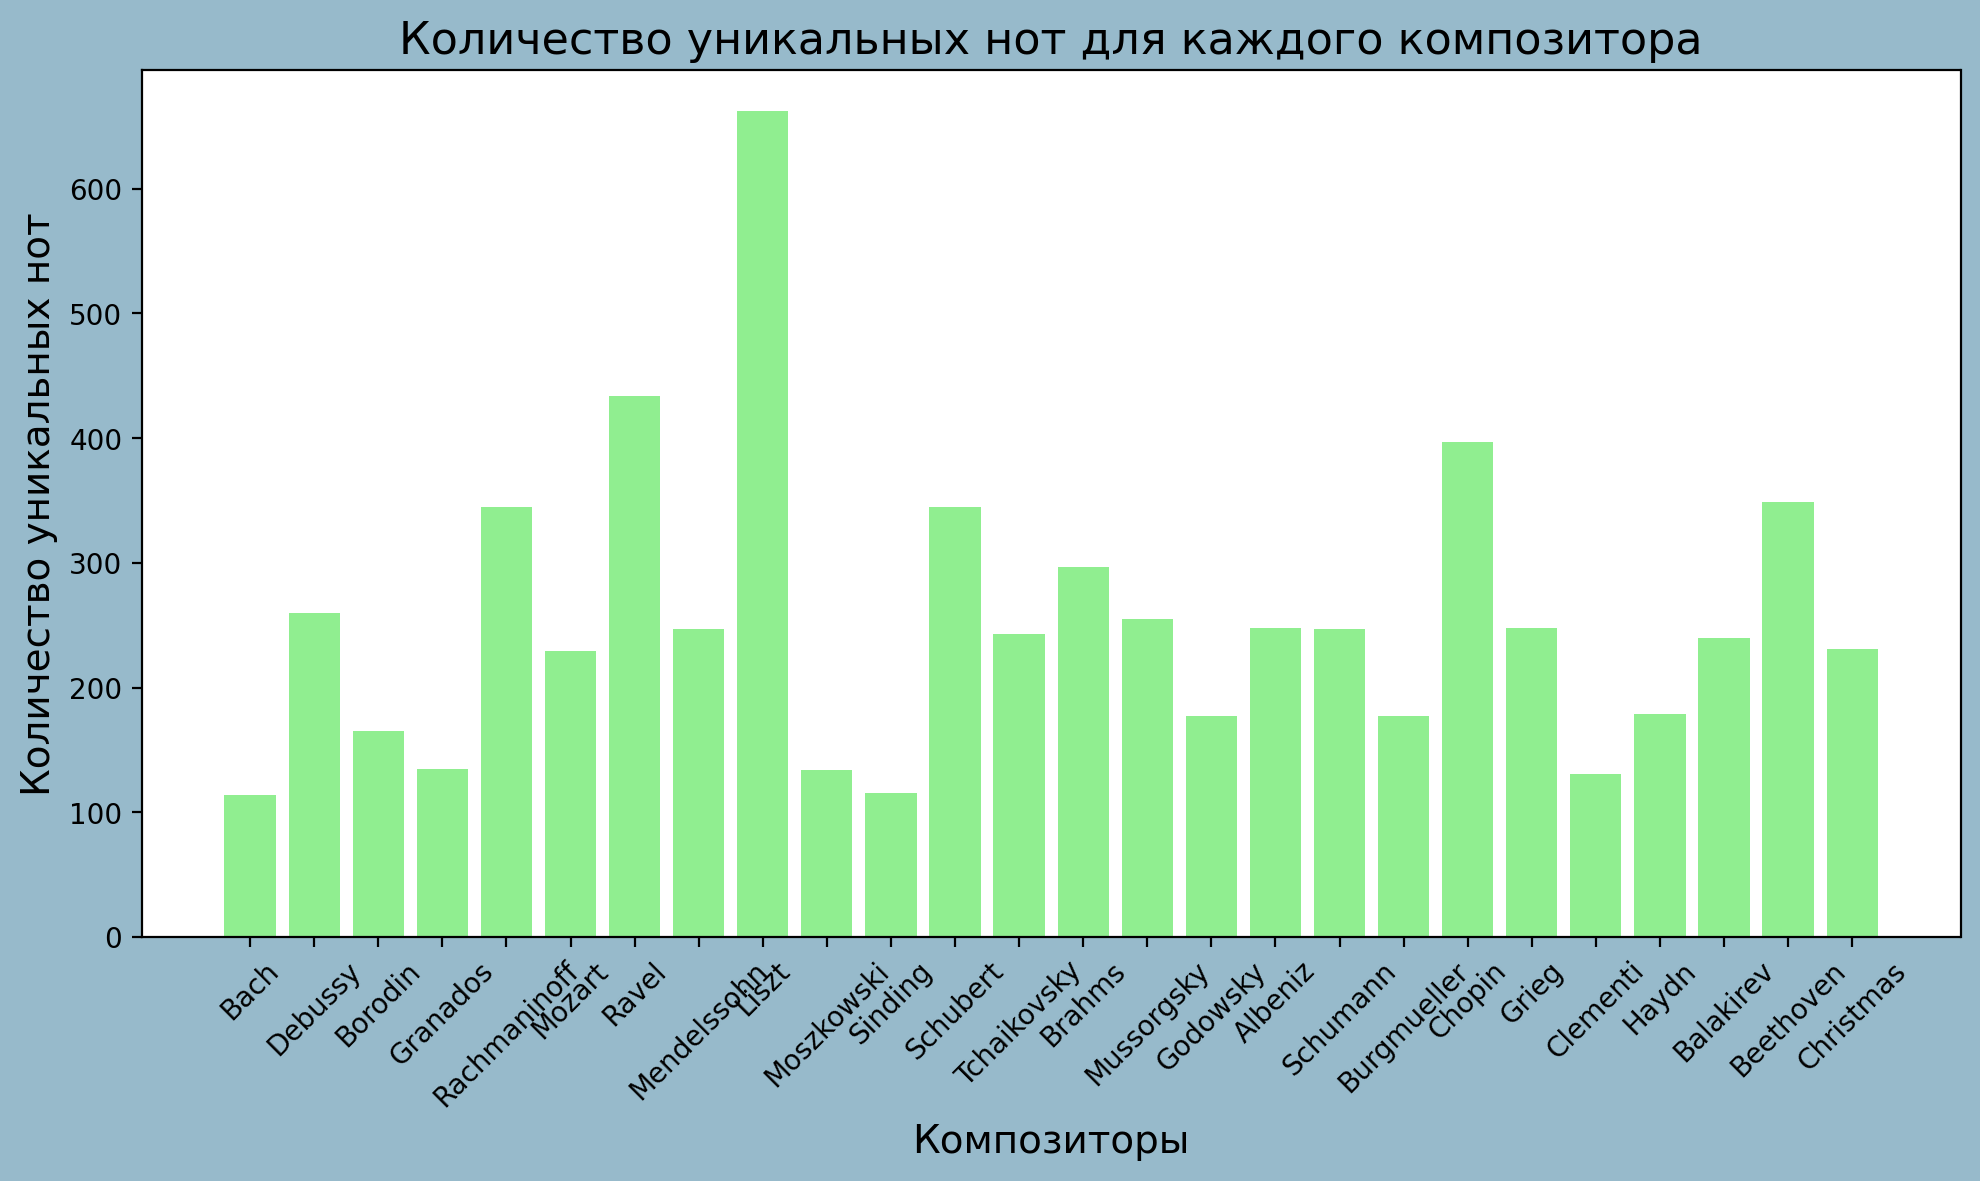

In [ ]:
plt.figure(figsize=(10, 6), facecolor='#97BACB')
plt.bar(unique_notes_counts.keys(), unique_notes_counts.values(), color='lightgreen')
plt.xlabel('Композиторы', fontsize=14)
plt.ylabel('Количество уникальных нот', fontsize=14)
plt.title('Количество уникальных нот для каждого композитора', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

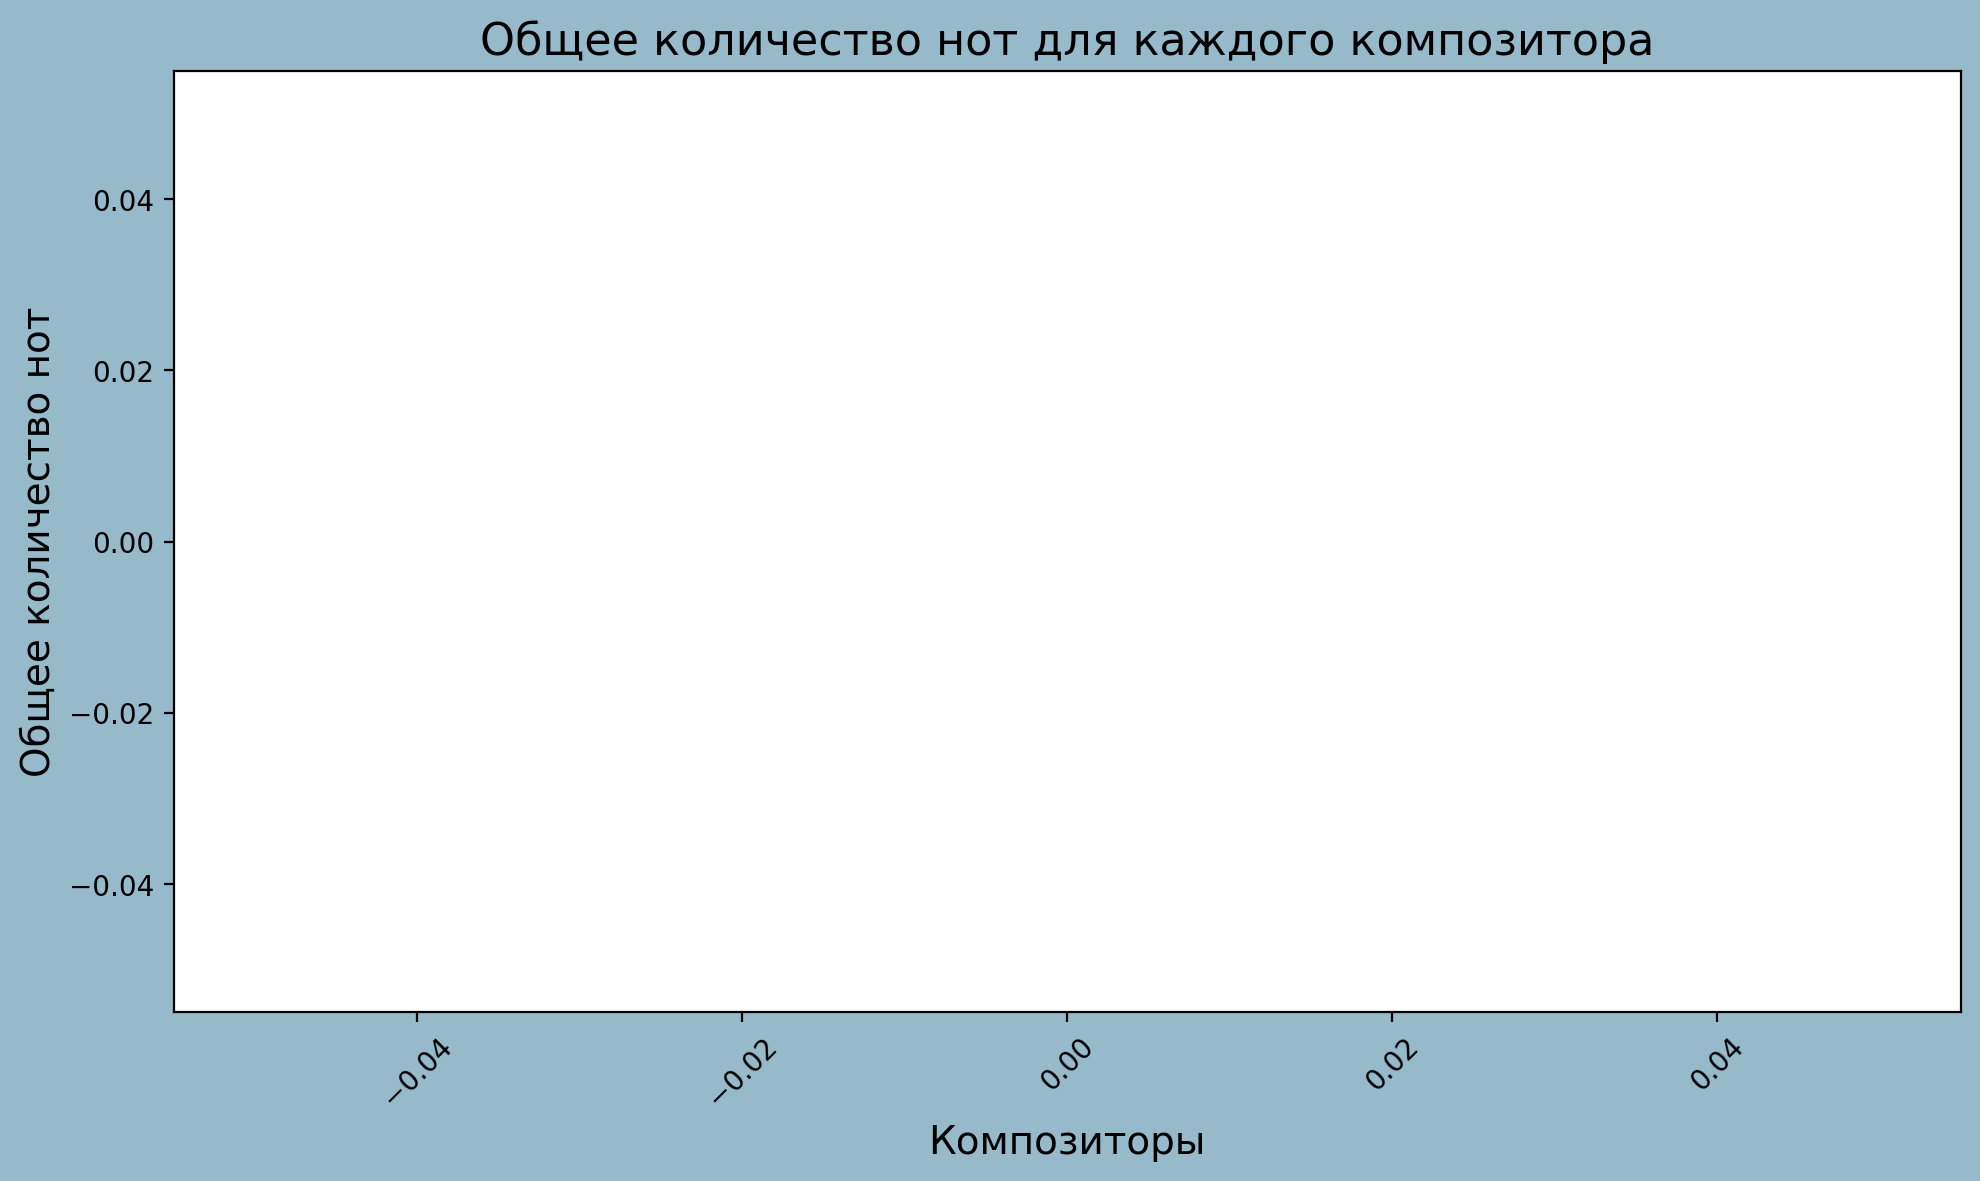

In [ ]:
plt.figure(figsize=(10, 6), facecolor='#97BACB')
plt.bar(all_notes_counts.keys(), all_notes_counts.values(), color='skyblue')
plt.xlabel('Композиторы', fontsize=14)
plt.ylabel('Общее количество нот', fontsize=14)
plt.title('Общее количество нот для каждого композитора', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
del composer_notes, composer_all_notes

Определим список композиторов, исходя из полученных данных

In [ ]:
selected_composers = ['Ravel', 'Schubert', 'Liszt', 'Mozart', 'Beethoven']

## Анализ отрывка композиции

In [ ]:
# Вывод первых 100 нот для композитора Mozart
mozart_filepath = os.path.join(DATASET_PATH, 'Mozart')
mozart_files = [f for f in os.listdir(mozart_filepath) if f.endswith('.mid')]
if mozart_files:
    first_mozart_piece_path = os.path.join(mozart_filepath, mozart_files[0])
    mozart_score = converter.parse(first_mozart_piece_path)
    notes = []
    for element in mozart_score.flat.notes[:100]:  # Извлекаем первые 100 нот
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes.append(".".join(str(n) for n in element.normalOrder))
    print("Первые 100 нот произведения Моцарта:")
    print(notes)

Первые 100 нот произведения Моцарта:
['B4', 'G3', 'D4', 'B3', 'D4', 'G3', 'D4', 'B3', 'D4', 'D5', 'A3', 'C5', 'D4', 'B4', 'C4', 'C5', 'D4', 'D5', 'C5', 'G3', 'D4', 'B3', 'B4', 'D4', 'G4', 'G3', 'D4', 'B3', 'D4', 'G3', 'D4', 'B3', 'D4', 'G5', 'G3', 'E4', 'C4', 'E4', 'G3', 'E4', 'A5', 'C4', 'G5', 'E4', 'F#5', 'G3', 'E5', 'C#4', 'D5', 'B-3', 'C#5', 'C#4', 'D5', 'C#5', 'G3', 'D4', 'B3', 'B4', 'D4', 'G4', 'G3', 'D4', 'B3', 'D4', 'G3', 'D4', 'B3', 'D4', 'C5', 'A3', 'D4', 'C4', 'A4', 'D4', 'F#4', 'A3', 'D4', 'A4', 'C4', 'D4', 'B4', 'A3', 'D4', 'C5', 'C4', 'D4', 'D5', 'G3', 'D4', 'B3', 'B4', 'D4', 'G5', 'E3', 'B3', 'G3', 'B3', 'B2', 'G3', 'D3']


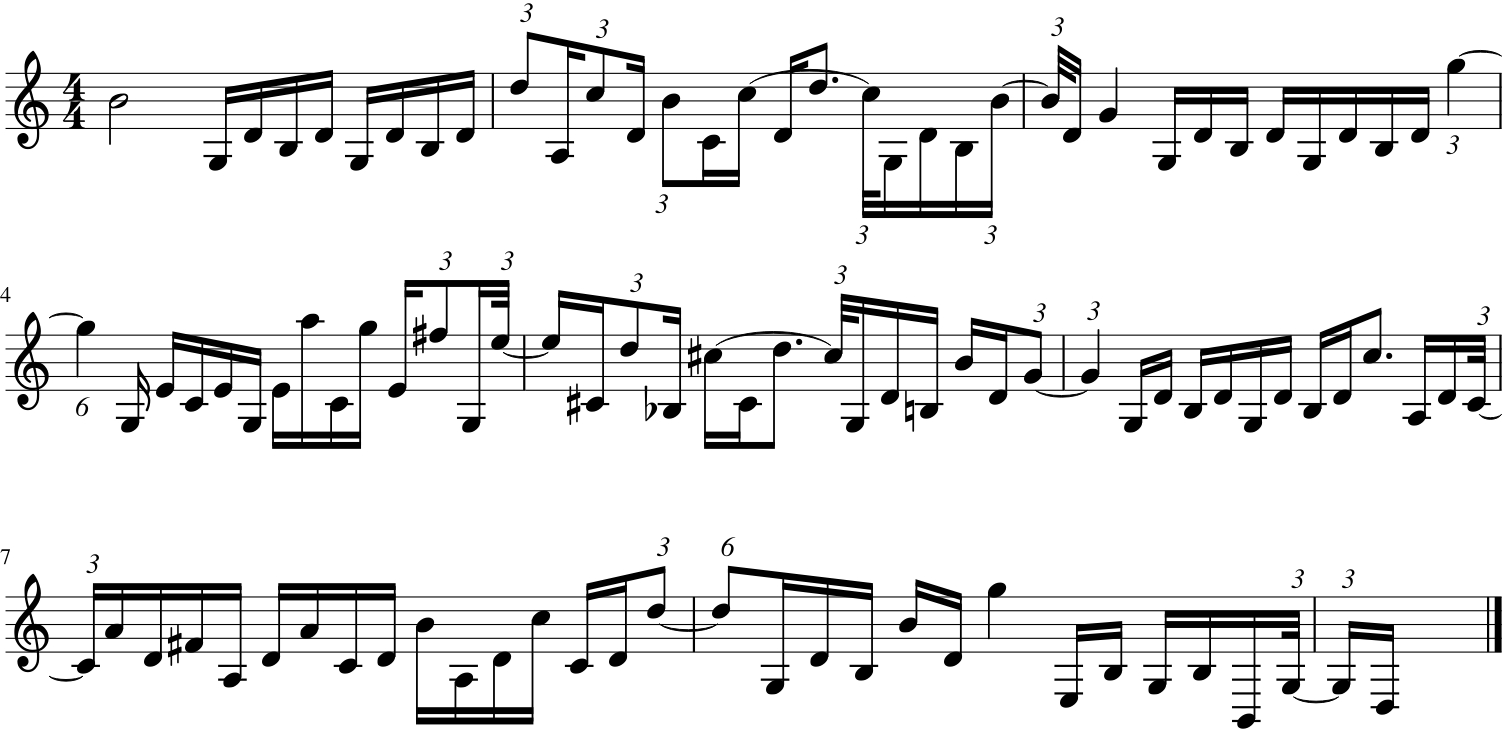

In [ ]:
notes_stream = stream.Stream()
for element in mozart_score.flat.notes[:100]:
    notes_stream.append(element)
notes_stream.show()  # Показываем нотный стан с первыми 100 нотами произведения Моцарта

In [ ]:
notes_stream.show('midi')

## Всего нот

In [ ]:
all_midis = []
for composer in selected_composers:
    filepath = os.path.join(DATASET_PATH, composer)
    for filename in os.listdir(filepath):
        if filename.endswith(".mid"):
            midi_path = os.path.join(filepath, filename)
            midi = converter.parse(midi_path)  # Чтение и парсинг MIDI-файлов в Stream-объект библиотеки music21
            all_midis.append(midi)

Функция для преобразования потока Stream midi-файлов в список нот

In [ ]:
def getNotes(files):
    notes = []
    for midi in files:
        songs = instrument.partitionByInstrument(midi)
        for part in songs.parts:
            notes_to_parse = part.recurse()
            for element in notes_to_parse:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))
    return notes

In [ ]:
Corpus = getNotes(all_midis)
print("Всего нот в корпусе midi-файлах:", len(Corpus))

Всего нот в корпусе midi-файлах: 276729


## Уникальные ноты

In [ ]:
count_num = Counter(Corpus)
print("Общее число уникальных нот в корпусе:", len(count_num))

Общее число уникальных нот в корпусе: 763


In [ ]:
Notes = list(count_num.keys())
Recurrence = list(count_num.values())

def Average(rec):
    return sum(rec) / len(rec)

print('Средняя повторяемость ноты:', Average(Recurrence))
print('Наиболее часто встречаемые ноты:', max(Recurrence), 'раз')
print('Наиболее редкие ноты:', min(Recurrence), 'раз')

Средняя повторяемость ноты: 362.68545216251636
Наиболее часто встречаемые ноты: 5934 раз
Наиболее редкие ноты: 1 раз


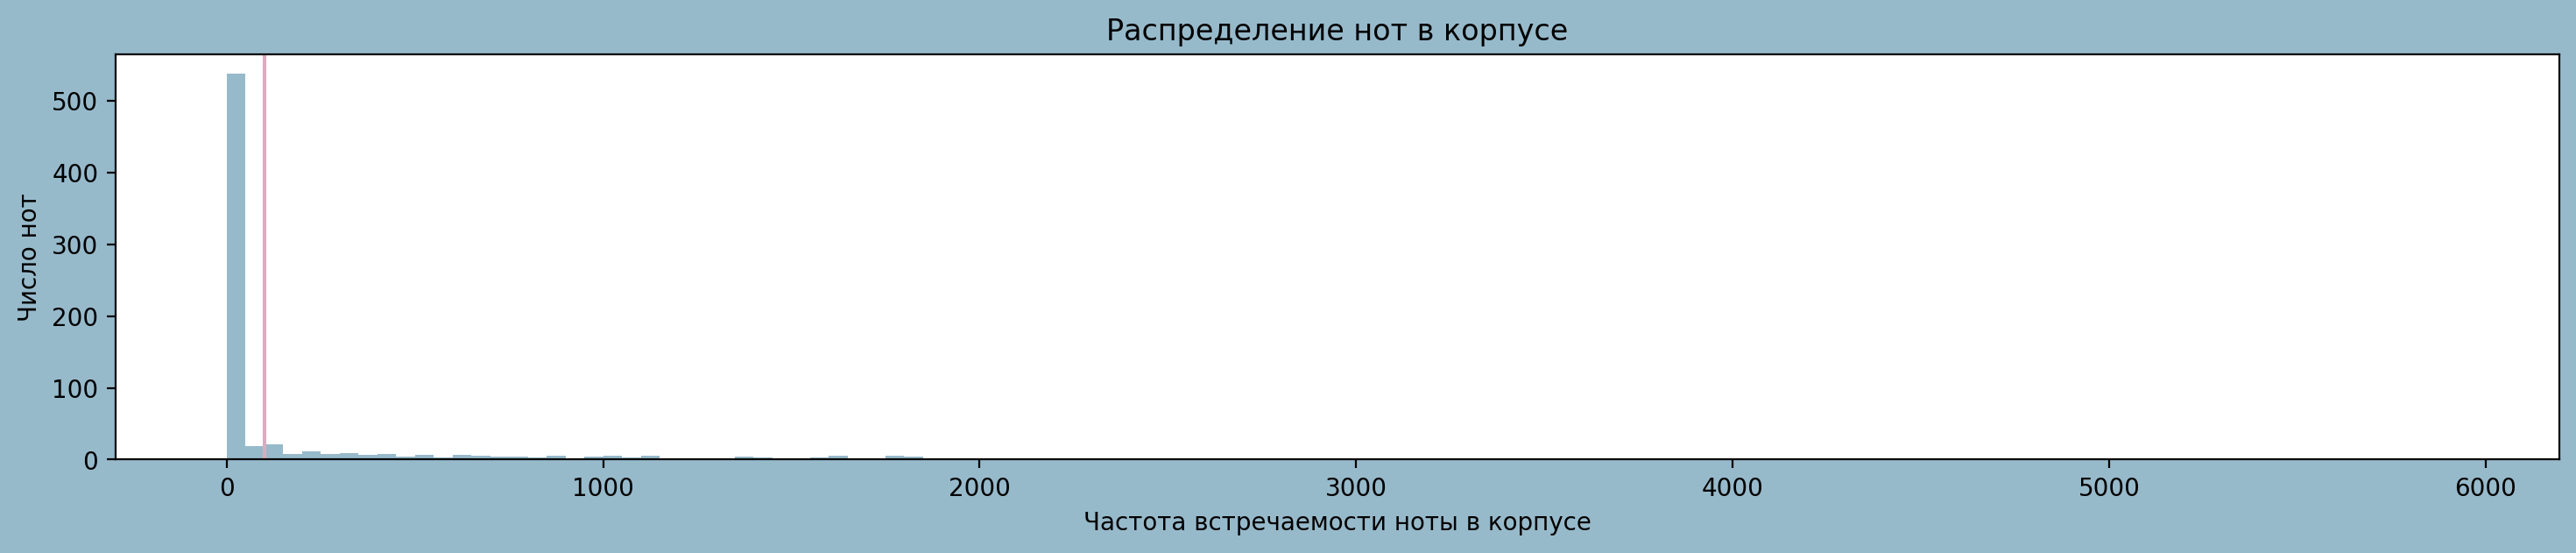

In [ ]:
plt.figure(figsize=(18, 3), facecolor='#97BACB')
bins = np.arange(0,(max(Recurrence)), 50)
plt.hist(Recurrence, bins=bins, color='#97BACB')
plt.axvline(x=100, color='#DBACC1') # отсечка по встречаемости в 100 раз
plt.title('Распределение нот в корпусе')
plt.xlabel('Частота встречаемости ноты в корпусе')
plt.ylabel('Число нот')
plt.show()

In [ ]:
# Получение списка редких нот
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)

print("Общее число нот, которые повторяются менее 100 раз:", len(rare_note))

Общее число нот, которые повторяются менее 100 раз: 556


In [ ]:
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Длина корпуса после исключения редких нот:", len(Corpus))

Длина корпуса после исключения редких нот: 271775


# Предобработка датасета

In [ ]:
# Сохраняем все уникальные значения корпуса
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) # длина корпуса
L_symb = len(symb) # число уникальных элементов корпуса

# Создание словаря для доступа к словарному запасу из индексов и наоборот
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Общее число символов:", L_corpus)
print("Число уникальных символов:", L_symb)

Общее число символов: 271775
Число уникальных символов: 519


## Разбиение корпуса

In [ ]:
# входные последовательности
features = []

# целевые последовательности
targets = []

# цикл разбиения корпуса
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])


L_datapoints = len(targets)
print("Общее количество последовательностей в корпусе:", L_datapoints)

Общее количество последовательностей в корпусе: 271735


## Нормализация

In [ ]:
# изменение размера и нормализация входных данных
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)

# one-hot encode для целевых выходных данных
y = tensorflow.keras.utils.to_categorical(targets)

print(f'Форма входных данных: {X.shape}')
print(f'Форма выходных данных: {y.shape}')

Форма входных данных: (271735, 40, 1)
Форма выходных данных: (271735, 519)


## Создание выборки

In [ ]:
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

# Архитектура модели

In [ ]:
model = Sequential()

model.add(LSTM(256, input_shape=X.shape[1:], return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(128))
model.add(Dense(128))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 40, 256)             │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 40, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 519)                 │          66,951 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 544,775 (2.08 MB)

 Trainable params: 544,775 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

## Callbacks

In [ ]:
# Определение колбэков
checkpoint = ModelCheckpoint('best_model.keras', monitor='loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='min')
callbacks_list = [checkpoint, early_stopping]

## Обучение

In [ ]:
# Обучение модели
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks_list)

Epoch 1/150
3393/3397 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.1912 - loss: 3.4087
Epoch 1: loss improved from 3.43655 to 3.42844, saving model to best_model.keras
3397/3397 ━━━━━━━━━━━━━━━━━━━━ 34s 10ms/step - acc: 0.1912 - loss: 3.4087
Epoch 2/150
3397/3397 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.1966 - loss: 3.3705
Epoch 2: loss improved from 3.42844 to 3.39039, saving model to best_model.keras
3397/3397 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - acc: 0.1966 - loss: 3.3705
Epoch 3/150
3392/3397 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.2019 - loss: 3.3410
Epoch 3: loss improved from 3.39039 to 3.36157, saving model to best_model.keras
3397/3397 ━━━━━━━━━━━━━━━━━━━━ 33s 10ms/step - acc: 0.2019 - loss: 3.3410
Epoch 4/150
3396/3397 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.2062 - loss: 3.3111
Epoch 4: loss improved from 3.36157 to 3.32833, saving model to best_model.keras
3397/3397 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - acc: 0.2062 - loss: 3.3111
Epoch 5/150
3396/3397 ━━━━━━━━━━━━━━━━━━━━

## Графики обучения

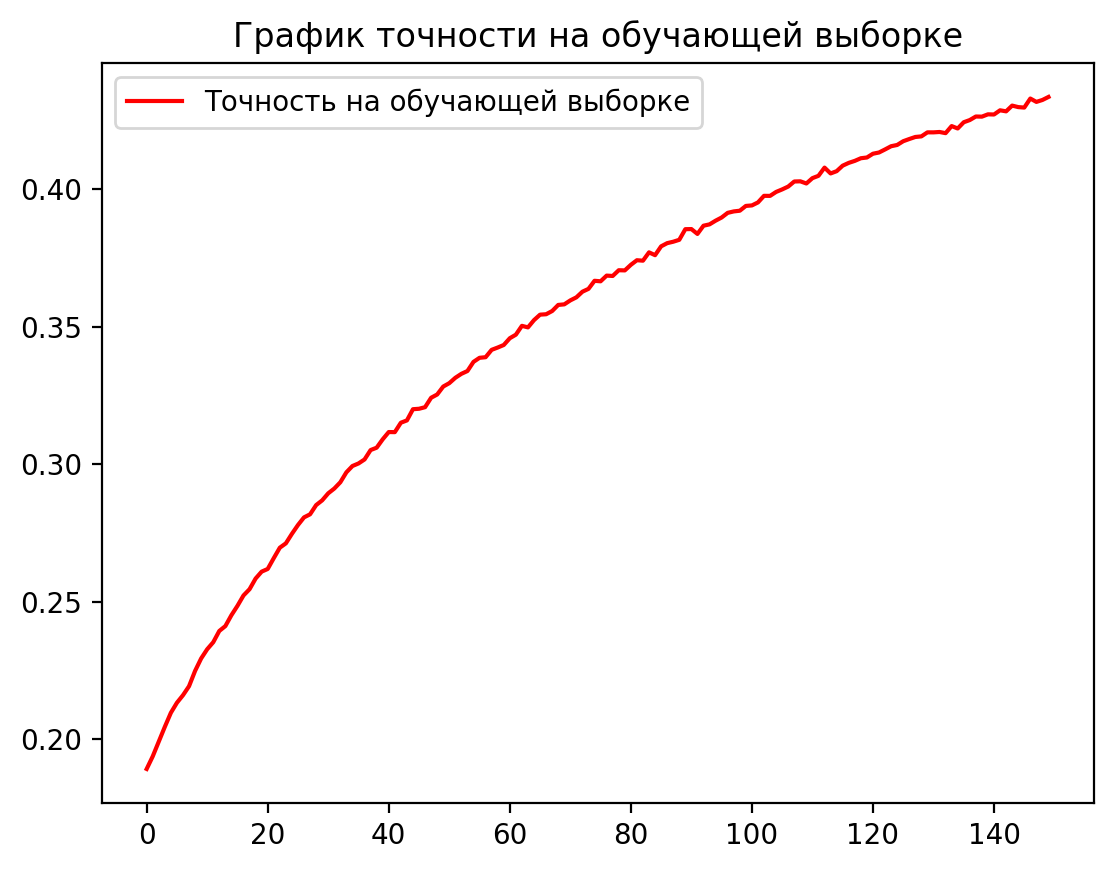

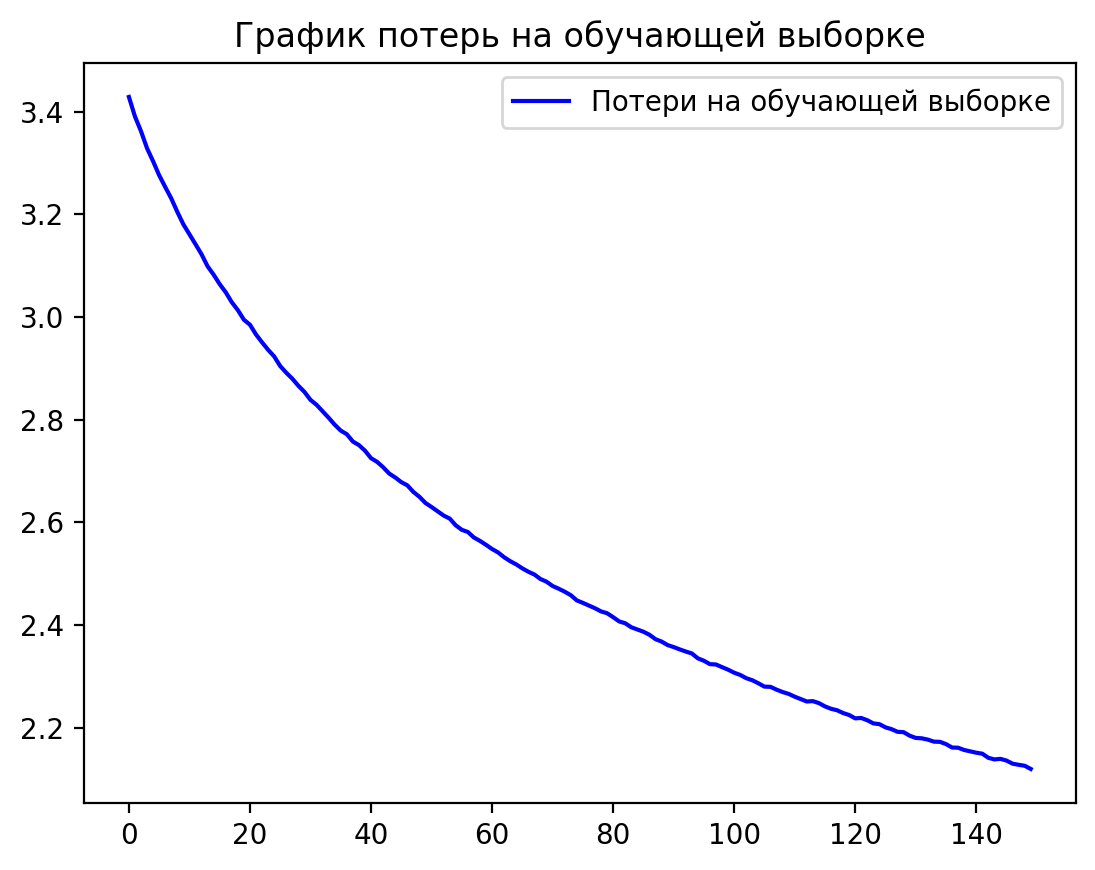

In [ ]:
plt.plot(history.epoch, history.history['acc'], 'r', label='Точность на обучающей выборке')
plt.title('График точности на обучающей выборке')
plt.legend()
plt.figure()
plt.plot(history.epoch, history.history['loss'], 'b', label='Потери на обучающей выборке')
plt.title('График потерь на обучающей выборке')
plt.legend()
plt.show()

Уровень обучения довольно низкий, но модель ещё способна учиться

# Генерация произведения

In [ ]:
def generate_music(model, length=100):
    # Выбор случайной начальной последовательности из обучающего набора
    start_index = random.randint(0, len(X_seed) - 1)
    pattern = X_seed[start_index]

    # Генерация нот
    generated_notes = []
    for _ in range(length):
        # Добавление измерения для предсказания
        prediction_input = np.reshape(pattern, (1, pattern.shape[0], 1))
        prediction = model.predict(prediction_input, verbose=0)

        # Определение следующей ноты на основе наибольшей вероятности
        index = np.argmax(prediction)
        result = reverse_mapping[index]
        generated_notes.append(result)

        # Обновление входного паттерна
        pattern = np.append(pattern[1:], [[index]], axis=0)

    return generated_notes
    for item in generated_notes:
        if '.' in item:
            chord_notes = [int(x) for x in item.split('.')]
            new_chord = chord.Chord(chord_notes)
            stream_output.append(new_chord)
        else:
            new_note = note.Note(item)
            stream_output.append(new_note)

In [ ]:
# Генерация музыкальной композиции
generated_notes = generate_music(model, length=100)

In [ ]:
# Восстановление нотной последовательности и воспроизведение
stream_output = stream.Stream()
for item in generated_notes:
    if '.' in item:
        chord_notes = [int(x) for x in item.split('.')]
        new_chord = chord.Chord(chord_notes)
        stream_output.append(new_chord)
    else:
        new_note = note.Note(item)
        stream_output.append(new_note)

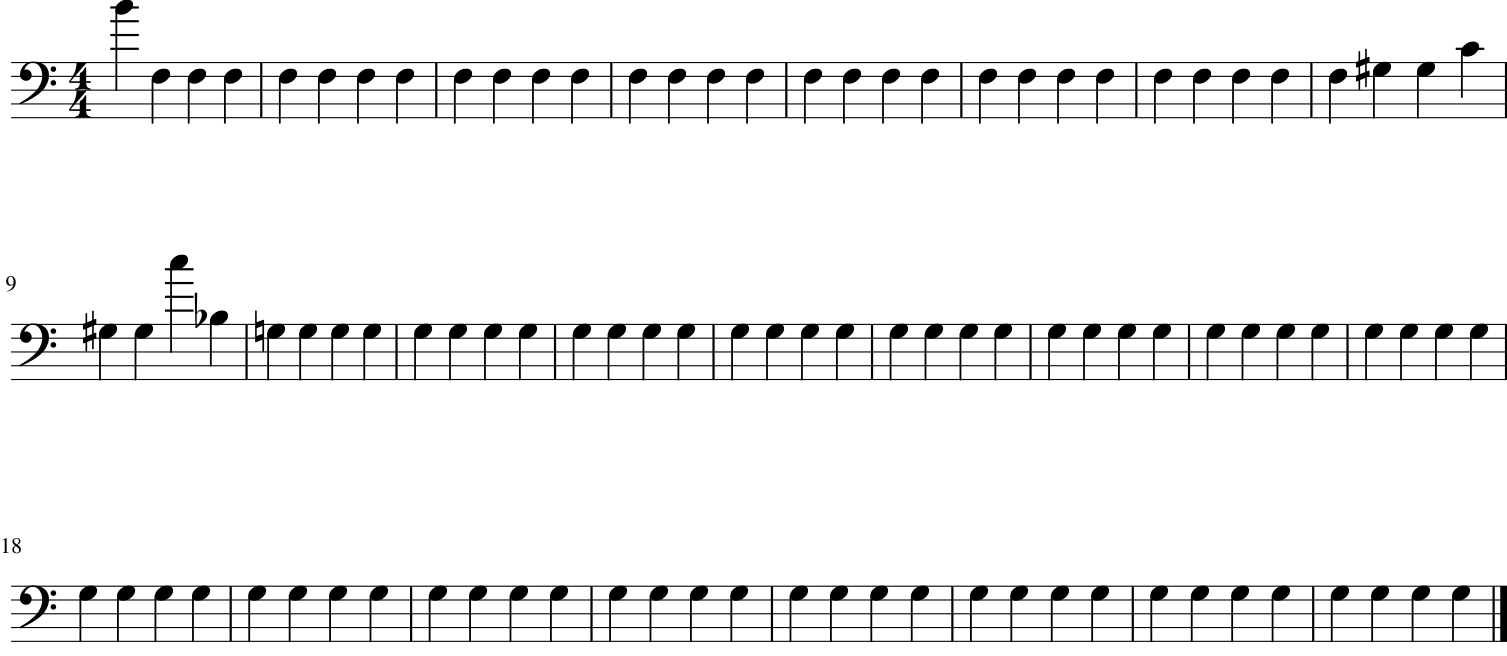

In [ ]:
# Отображение нотного стана
stream_output.show()

In [ ]:
# Воспроизведение сгенерированной последовательности
stream_output.show('midi')